# Reimplementing the Adversarially Reweighted Learning model by Lahoti et al. (2020) to improve fairness without demographics



This notebook contains the results presented in the paper by J. Mohazzab, L. Weytingh, C. Wortmann, and B. Brocades Zaalberg. More specifically, it contains the presented results for replicating [the paper by Lahoti et al.](https://arxiv.org/abs/2006.13114). In addition, this notebook includes the significance tests presented in Section 3.4.1 of the paper.

In [6]:
import copy
import time
import train
from argparser import DefaultArguments, get_optimal_parameters
from significance import test_significance
from glob import glob
import os
import traceback
import shap

from arl import ARL
from dataloader import *

import pickle

## Remember to edit train.py to save model before doing these calcs

### Default Parameters

The default parameters are loaded below. They can be changed, e.g. for speeding up the training. 

In [7]:
# Load the default arguments
default_args = DefaultArguments()

# Change if the loss should be printed
default_args.print_loss = False

# Change the amount of times the results are averaged here.
default_args.average_over = 10

# Change the amount of training steps for each of the datasets here.
training_steps = {
    "uci_adult": 990,
    "law_school": 990,
    "compas": 470,
}

print("The default parameters are:\n", default_args.__dict__)

The default parameters are:
 {'average_over': 10, 'dataset': 'compas', 'train_steps': 1000, 'pretrain_steps': 250, 'batch_size': 32, 'optimizer': 'Adagrad', 'embedding_size': 32, 'lr_learner': 0.01, 'lr_adversary': 0.01, 'test_every': 5, 'seed': 42, 'log_dir': 'logs/', 'res_dir': 'results/', 'print_loss': False, 'model_name': 'ARL'}


## Replicability

The presented results for the PyTorch implementation are generated below for each classification task.

In [8]:
def dothings(ipath, name):
    # Load the default arguments
    default_args = DefaultArguments()

    # Change if the loss should be printed
    default_args.print_loss = False

    # Change the amount of times the results are averaged here.
    default_args.average_over = 10

    # Change the amount of training steps for each of the datasets here.
    training_steps = {
        "uci_adult": 990,
        "law_school": 990,
        "compas": 470,
    }


    adult_params = get_optimal_parameters("uci_adult")
    adult_params["train_steps"] = training_steps["uci_adult"]

    # Load the arguments passed to the training function.
    adult_args = copy.copy(default_args)
    adult_args.dataset = ipath
    adult_args.update(adult_params)

    args = adult_args

    train_dataset = loadDataset(
        dataset=args.dataset,
        train_or_test="train",
        embedding_size=args.embedding_size,
    )
    test_dataset = loadDataset(dataset=args.dataset, train_or_test="test")

    # Set the model parameters. 
    model_params = {}
    model_params["learner_hidden_units"] = [64, 32]
    model_params["batch_size"] = args.batch_size
    model_params["embedding_size"] = train_dataset.categorical_embedding_sizes
    model_params["n_num_cols"] = len(train_dataset.mean_std.keys())
    model_params["adversary_hidden_units"] = [32]

    device = "cpu"#"cuda:1" if torch.cuda.is_available() else "cpu"
    model_params["device"] = device
    
    model = ARL(**model_params)
    
    model.load_state_dict(torch.load(ipath+'/preds/ARL_model.pt'))
    model.eval()
    
    
    def getsubset(bigarray, n):
        number_of_rows = bigarray.shape[0]
        random_indices = np.random.choice(number_of_rows, 
                                          size=n, 
                                          replace=False)
        subset = bigarray[random_indices, :]
        return subset

    def f(subset):
        cat = torch.tensor(subset[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15,16,17]]).to(torch.int64)
        num = torch.tensor(subset[:, [18,19,20,21,22,23,24,25,26]]).to(torch.int64)
        prot = torch.tensor(subset[:, [27]]).to(torch.int64)
        test_pred = None
        with torch.no_grad():
            test_logits, test_sigmoid, test_pred = model.learner(cat, num)
        return test_pred
    
    test_dataset = loadDataset(dataset=args.dataset, train_or_test="test")
    test_cat, test_num, test_target = test_dataset[:]
    test_prot = test_dataset.protected_data
    bigarray = np.array(torch.cat((test_cat,test_num,test_prot), 1))


    explainer = shap.Explainer(f, bigarray)
    shap_values = explainer(getsubset(bigarray,500))
    
    COLS =  ['race', 'admissiontypeid', 'dischargedispositionid', 'admissionsourceid',
            'diag1', 'diag2', 'diag3','maxgluserum', 'A1Cresult','metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
            'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'age', 'timeinhospital', 'numlabprocedures',
       'numprocedures', 'nummedications', 'numberoutpatient',
       'numberemergency', 'numberinpatient', 'numberdiagnoses', 'sex']

    clist = COLS
    features = {}
    for i in range(len(clist)):
        fname = clist[i]
        item = fname.split('_')[0]
        if item not in features:
            features[item]=[]
        features[item].append(i)
    newshap = {}
    for k in features:
        nshap = []
        for x in shap_values.values:
            val = 0
            for i in features[k]:
                val+= x[i]
            nshap.append(val)
        newshap[k] = nshap
    new_shap_values = list(zip(*newshap.values()))
    shap_values.values = np.array(new_shap_values)
    shap_values.feature_names = list(features.keys())
    
    f = open('../SavedShap/'+name+'.pkl','wb')
    pickle.dump(shap_values,f)
    f.close()
    
    
    shap.plots.bar(shap_values,max_display=18)

In [9]:
paths = {0:'../data/datasets/diabetes/',
         0.2:'../data/datasets/diabetes/synthetic/gender_flip_labels0.2_version0/',
         0.4:'../data/datasets/diabetes/synthetic/gender_flip_labels0.4_version0/',
         0.6:'../data/datasets/diabetes/synthetic/gender_flip_labels0.6_version0/',
         0.8:'../data/datasets/diabetes/synthetic/gender_flip_labels0.8_version0/'
        }

../data/datasets/diabetes/
Parameters used for the credit dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.659 ± 0.0032
Average AUC(macro-avg): 0.659
Average AUC(min): 0.653
Average AUC(minority): 0.665
-----------------------------------

Training and evaluating took, on average, 42 seconds per model iteration


Permutation explainer: 501it [00:20, 14.51it/s]                         


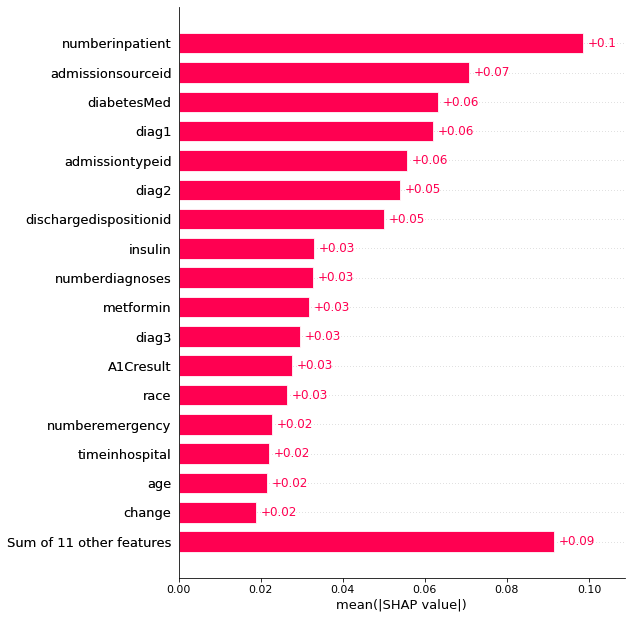

../data/datasets/diabetes/synthetic/gender_flip_labels0.2_version0/
Parameters used for the credit dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.644 ± 0.0031
Average AUC(macro-avg): 0.644
Average AUC(min): 0.642
Average AUC(minority): 0.645
-----------------------------------

Training and evaluating took, on average, 57 seconds per model iteration


Permutation explainer: 501it [00:28, 11.11it/s]                         


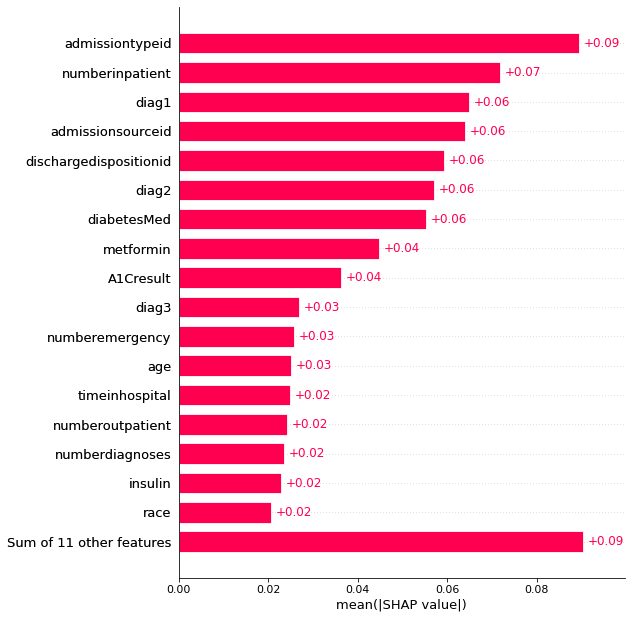

../data/datasets/diabetes/synthetic/gender_flip_labels0.4_version0/
Parameters used for the credit dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.641 ± 0.0031
Average AUC(macro-avg): 0.641
Average AUC(min): 0.635
Average AUC(minority): 0.635
-----------------------------------

Training and evaluating took, on average, 64 seconds per model iteration


Permutation explainer: 501it [00:28, 12.80it/s]                         


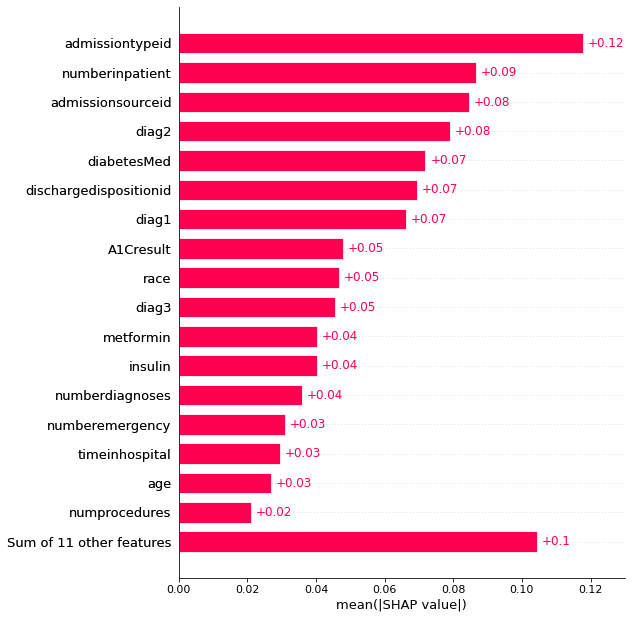

../data/datasets/diabetes/synthetic/gender_flip_labels0.6_version0/
Parameters used for the credit dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.639 ± 0.0040
Average AUC(macro-avg): 0.639
Average AUC(min): 0.637
Average AUC(minority): 0.637
-----------------------------------

Training and evaluating took, on average, 49 seconds per model iteration


Permutation explainer: 501it [00:15, 10.29it/s]                         


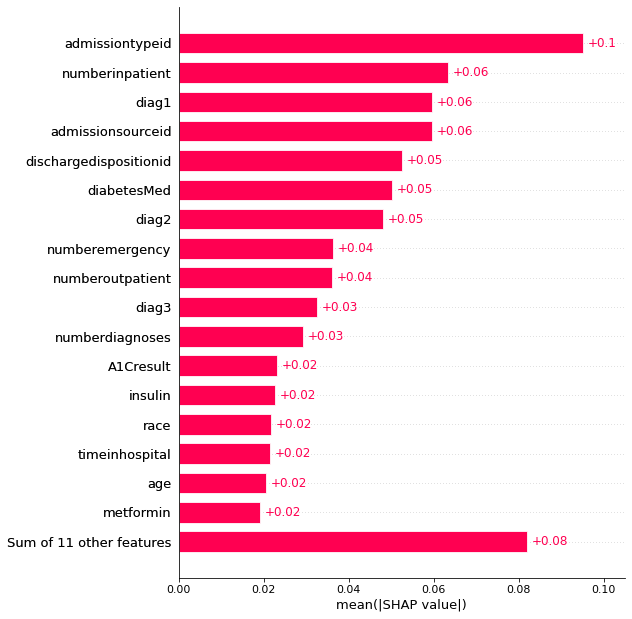

../data/datasets/diabetes/synthetic/gender_flip_labels0.8_version0/
Parameters used for the credit dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.653 ± 0.0027
Average AUC(macro-avg): 0.653
Average AUC(min): 0.651
Average AUC(minority): 0.654
-----------------------------------

Training and evaluating took, on average, 54 seconds per model iteration


Permutation explainer: 501it [00:16, 12.23it/s]                         


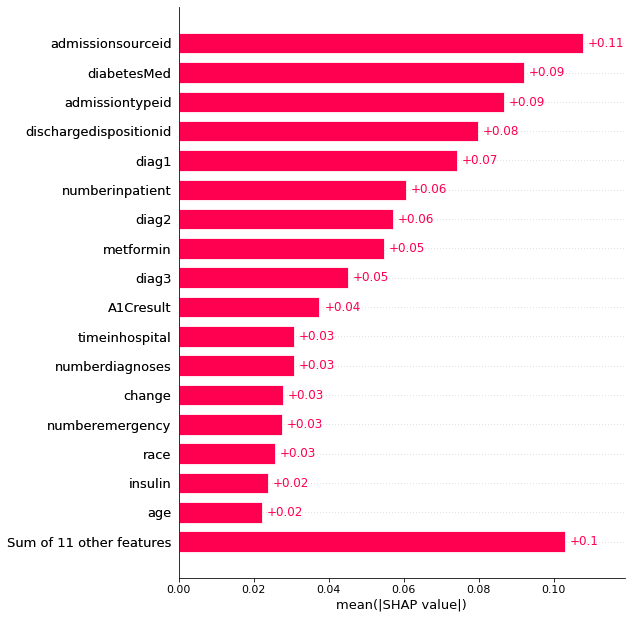

In [10]:
# Load the optimal hyperparameters.
for frac in paths:
    path = paths[frac]
    gname = 'diabetes'
    print(path)
    adult_params = get_optimal_parameters("uci_adult")
    adult_params["train_steps"] = training_steps["uci_adult"]

    # Load the arguments passed to the training function.
    adult_args = copy.copy(default_args)
    adult_args.dataset = path
    adult_args.update(adult_params)

    print("Parameters used for the credit dataset:\n", adult_params)

    # Start timing.
    adult_start = time.time()

    # Train the model.
    train.main(adult_args)

    # Save the timing results.
    adult_time = (time.time() - adult_start) / adult_args.average_over
    print(f"Training and evaluating took, on average, {adult_time:.0f} seconds per model iteration")
    
    name = gname+'_ARL_'+str(frac)
    dothings(path,name)

In [11]:
def dothings2(ipath, name):
    # Load the default arguments
    default_args = DefaultArguments()

    # Change if the loss should be printed
    default_args.print_loss = False

    # Change the amount of times the results are averaged here.
    default_args.average_over = 10

    # Change the amount of training steps for each of the datasets here.
    training_steps = {
        "uci_adult": 990,
        "law_school": 990,
        "compas": 470,
    }


    adult_params = get_optimal_parameters("uci_adult")
    adult_params["train_steps"] = training_steps["uci_adult"]

    # Load the arguments passed to the training function.
    adult_args = copy.copy(default_args)
    adult_args.dataset = ipath
    adult_args.update(adult_params)

    args = adult_args

    train_dataset = loadDataset(
        dataset=args.dataset,
        train_or_test="train",
        embedding_size=args.embedding_size,
    )
    test_dataset = loadDataset(dataset=args.dataset, train_or_test="test")

    # Set the model parameters. 
    model_params = {}
    model_params["learner_hidden_units"] = [64, 32]
    model_params["batch_size"] = args.batch_size
    model_params["embedding_size"] = train_dataset.categorical_embedding_sizes
    model_params["n_num_cols"] = len(train_dataset.mean_std.keys())
    model_params["adversary_hidden_units"] = [32]

    device = "cpu"#"cuda:1" if torch.cuda.is_available() else "cpu"
    model_params["device"] = device
    
    model = ARL(**model_params)
    
    model.load_state_dict(torch.load(ipath+'/preds/ARL_model.pt'))
    model.eval()
    
    
    
    def getsubset(bigarray, n):
        number_of_rows = bigarray.shape[0]
        random_indices = np.random.choice(number_of_rows, 
                                          size=n, 
                                          replace=False)
        subset = bigarray[random_indices, :]
        return subset

    def f(subset):
        cat = torch.tensor(subset[:, [0, 1]]).to(torch.int64)
        num = torch.tensor(subset[:, [2,3,4,5,6,7,8,9]]).to(torch.int64)
        prot = torch.tensor(subset[:, [10]]).to(torch.int64)
        test_pred = None
        with torch.no_grad():
            test_logits, test_sigmoid, test_pred = model.learner(cat, num)
        return test_pred
    
    test_dataset = loadDataset(dataset=args.dataset, train_or_test="test")
    test_cat, test_num, test_target = test_dataset[:]
    test_prot = test_dataset.protected_data
    bigarray = np.array(torch.cat((test_cat,test_num,test_prot), 1))


    explainer = shap.Explainer(f, bigarray)
    shap_values = explainer(getsubset(bigarray,500))
    
    COLS =  ['isPartTime', 'race','zfygpa', 'zgpa', 'DOByr', 'weightedlsatugpa', 'clustertier',
           'familyincome', 'lsat', 'ugpa','sex']
    
    clist = COLS
    features = {}
    for i in range(len(clist)):
        fname = clist[i]
        item = fname.split('_')[0]
        if item not in features:
            features[item]=[]
        features[item].append(i)
    newshap = {}
    for k in features:
        nshap = []
        for x in shap_values.values:
            val = 0
            for i in features[k]:
                val+= x[i]
            nshap.append(val)
        newshap[k] = nshap
    new_shap_values = list(zip(*newshap.values()))
    shap_values.values = np.array(new_shap_values)
    shap_values.feature_names = list(features.keys())
    
    f = open('../SavedShap/'+name+'.pkl','wb')
    pickle.dump(shap_values,f)
    f.close()
    
    
    shap.plots.bar(shap_values,max_display=18)

In [17]:
paths = {0:'../data/datasets/law_school/',
         0.2:'../data/datasets/law_school/synthetic/gender_flip_labels0.2_version0/',
         0.4:'../data/datasets/law_school/synthetic/gender_flip_labels0.4_version0/',
         0.6:'../data/datasets/law_school/synthetic/gender_flip_labels0.6_version0/',
         0.8:'../data/datasets/law_school/synthetic/gender_flip_labels0.8_version0/'
        }

../data/datasets/law_school/synthetic/gender_flip_labels0.4_version0/
Parameters used for the employment dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.783 ± 0.0063
Average AUC(macro-avg): 0.783
Average AUC(min): 0.776
Average AUC(minority): 0.776
-----------------------------------

Training and evaluating took, on average, 17 seconds per model iteration


Permutation explainer: 501it [00:15, 11.38it/s]                         


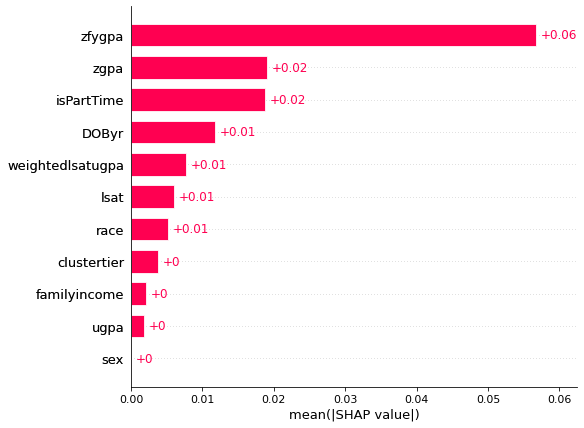

../data/datasets/law_school/synthetic/gender_flip_labels0.6_version0/
Parameters used for the employment dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.774 ± 0.0057
Average AUC(macro-avg): 0.774
Average AUC(min): 0.773
Average AUC(minority): 0.774
-----------------------------------

Training and evaluating took, on average, 16 seconds per model iteration


Permutation explainer: 501it [00:15, 11.44it/s]                         


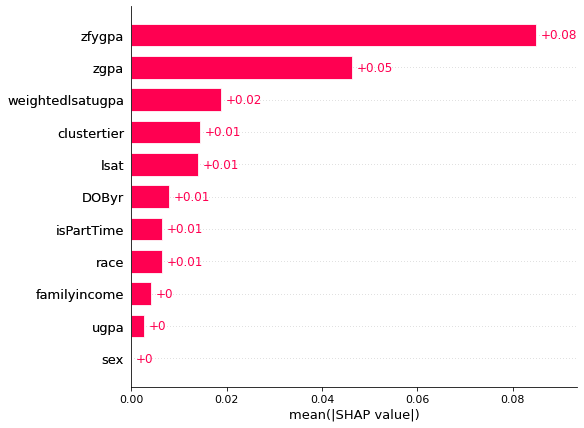

../data/datasets/law_school/synthetic/gender_flip_labels0.8_version0/
Parameters used for the employment dataset:
 {'batch_size': 256, 'lr_learner': 0.01, 'lr_adversary': 1, 'train_steps': 990}
Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10
Done training

-----------------------------------
Results

Average AUC: 0.787 ± 0.0063
Average AUC(macro-avg): 0.787
Average AUC(min): 0.782
Average AUC(minority): 0.793
-----------------------------------

Training and evaluating took, on average, 17 seconds per model iteration


Permutation explainer: 501it [00:15, 11.38it/s]                         


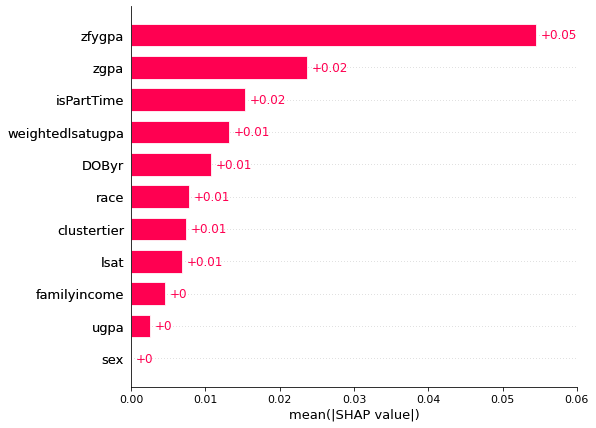

In [18]:
# Load the optimal hyperparameters.
for frac in paths:
    path = paths[frac]
    gname = 'law_school'
    print(path)
    adult_params = get_optimal_parameters("uci_adult")
    adult_params["train_steps"] = training_steps["uci_adult"]

    # Load the arguments passed to the training function.
    adult_args = copy.copy(default_args)
    adult_args.dataset = path
    adult_args.update(adult_params)

    print("Parameters used for the employment dataset:\n", adult_params)

    # Start timing.
    adult_start = time.time()

    # Train the model.
    train.main(adult_args)

    # Save the timing results.
    adult_time = (time.time() - adult_start) / adult_args.average_over
    print(f"Training and evaluating took, on average, {adult_time:.0f} seconds per model iteration")
    
    name = gname+'_ARL_'+str(frac)
    dothings2(path,name)